# RBE595:Hands-On Autonomous Aerial Robotics
## Project 0 Alohomora
### Phase 1: IMU Attitude Estimation

Data Loading

In [3]:
from scipy import io
import numpy as np
from scipy.spatial.transform import Rotation as R
import os

%matplotlib inline
from rotplot import rotplot
import matplotlib.pyplot as plt
import time

from DataLoader import *
from DataIterator import *
# trial_num = 1
# imu_data_raw = io.loadmat("Data/Train/IMU/imuRaw{}.mat".format(trial_num))
# vicon_data_raw = io.loadmat("Data/Train/Vicon/viconRot{}.mat".format(trial_num))

# imu_params = io.loadmat("IMUParams.mat")

# data_idx = 0
# vicon_idx = 0
# while data_idx < imu_data_raw["ts"].size and vicon_idx < vicon_data_raw["ts"].size:
#     if abs(imu_data_raw["ts"][:,data_idx] - vicon_data_raw["ts"][:,vicon_idx]) < 0.001:
#         break

#     if imu_data_raw["ts"][:,data_idx] < vicon_data_raw["ts"][:,vicon_idx]:
#         data_idx += 1
#     else:
#         vicon_idx += 1

# imu_data_raw["vals"] = imu_data_raw["vals"][:,data_idx:]
# imu_data_raw["ts"] = imu_data_raw["ts"][:,data_idx:]
# vicon_data_raw["rots"] = vicon_data_raw["rots"][:,:,vicon_idx:]
# vicon_data_raw["ts"] = vicon_data_raw["ts"][:,vicon_idx:]

In [4]:
trial_num = 1
imu_path = "Data/Train/IMU/imuRaw{}.mat".format(trial_num)
imu_data_loader = MatDataLoader(imu_path)
imu_data = IMUDataset(imu_data_loader)

vicon_path = "Data/Train/Vicon/viconRot{}.mat".format(trial_num)
vicon_data_loader = MatDataLoader(vicon_path)
vicon_data = ViconDataset(vicon_data_loader)

accel_param_path = "IMUParams.mat"
accel_param_loader = MatDataLoader(accel_param_path)
accel_param = AccelParam(accel_param_loader)

imu_idx, vicon_idx = findCommonStartTimeIdx(imu_data.ts, vicon_data.ts)
imu_data.removeDataBeforeIdx(imu_idx)
vicon_data.removeDataBeforeIdx(vicon_idx)
imu_data.correctBias(accel_param)
# imu_ax_raw = imu_data_raw["vals"][0,:]
# imu_ay_raw = imu_data_raw["vals"][1,:]
# imu_az_raw = imu_data_raw["vals"][2,:]
# imu_wz_raw = imu_data_raw["vals"][3,:]
# imu_wx_raw = imu_data_raw["vals"][4,:]
# imu_wy_raw = imu_data_raw["vals"][5,:]

# bias_ax = imu_params["IMUParams"][1,0]
# bias_ay = imu_params["IMUParams"][1,1]
# bias_az = imu_params["IMUParams"][1,2]
# scale_x = imu_params["IMUParams"][0,0]
# scale_y = imu_params["IMUParams"][0,1]
# scale_z = imu_params["IMUParams"][0,2]

# imu_ax = imu_ax_raw*scale_x + bias_ax
# imu_ay = imu_ay_raw*scale_y + bias_ay
# imu_az = imu_az_raw*scale_z + bias_az

# bias_gwx = np.average(imu_wx_raw[0:100])
# bias_gwy = np.average(imu_wy_raw[0:100])
# bias_gwz = np.average(imu_wz_raw[0:100])

# imu_wx = (3300/1023)*(np.pi/180)*0.3*(imu_wx_raw - bias_gwx)
# imu_wy = (3300/1023)*(np.pi/180)*0.3*(imu_wy_raw - bias_gwy)
# imu_wz = (3300/1023)*(np.pi/180)*0.3*(imu_wz_raw - bias_gwz)





### Orientation based on gyro data

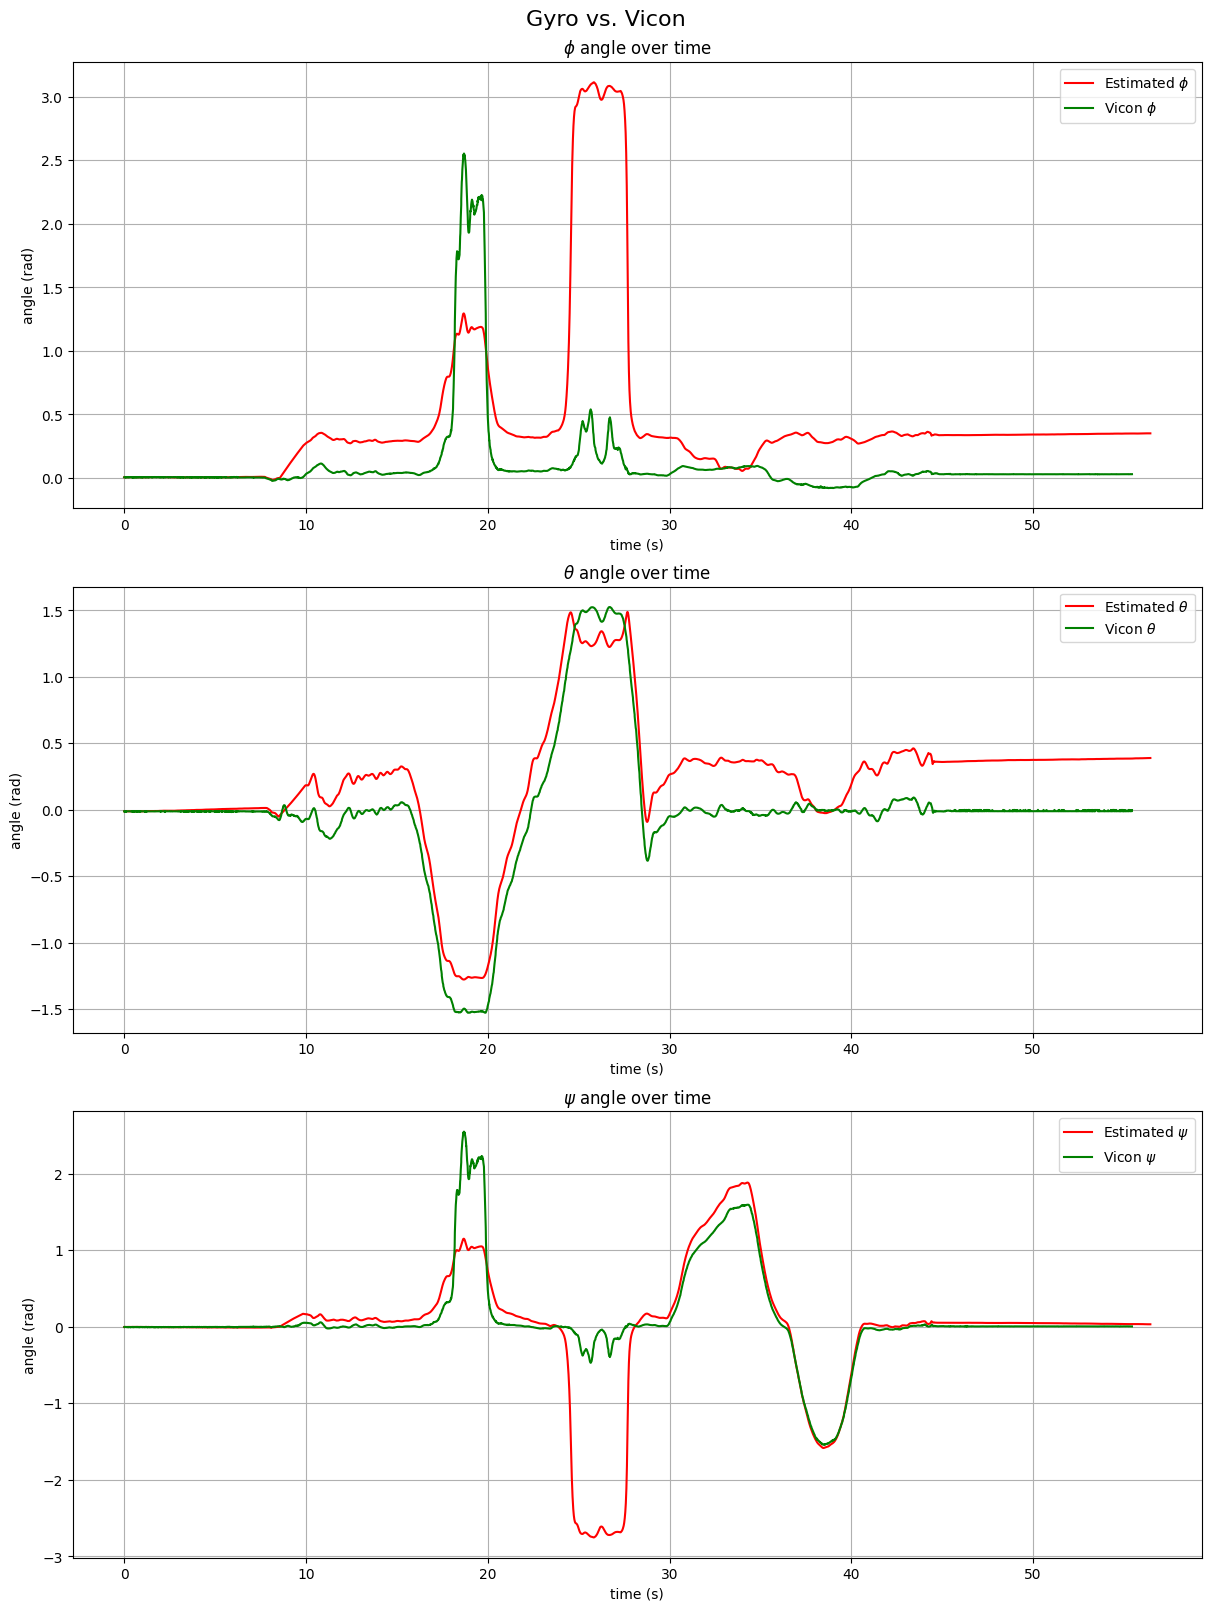

In [5]:
def IntegrateGyro(euler_init, dt, w):
    return euler_init + w*dt

def PlotEulerAnglesOverTime(esitmiatd_euler_angles, time, vicon_euler_angles, vicon_time):
    fig, ax = plt.subplots(3,figsize=(12,16),constrained_layout=True)
    ax[0].plot(time[0],esitmiatd_euler_angles[:,0,:][0],'r-',label='Estimated $\phi$')
    ax[1].plot(time[0],esitmiatd_euler_angles[:,1,:][0],'r-',label='Estimated $\\theta$')
    ax[2].plot(time[0],esitmiatd_euler_angles[:,2,:][0],'r-',label='Estimated $\psi$')

    ax[0].plot(vicon_time[0],vicon_euler_angles[:,0,:][0],'g-',label='Vicon $\phi$')
    ax[1].plot(vicon_time[0],vicon_euler_angles[:,1,:][0],'g-',label='Vicon $\\theta$')
    ax[2].plot(vicon_time[0],vicon_euler_angles[:,2,:][0],'g-',label='Vicon $\psi$')

    ax[0].set(xlabel='time (s)', ylabel='angle (rad)',
       title='$\phi$ angle over time')
    ax[1].set(xlabel='time (s)', ylabel='angle (rad)',
       title='$\\theta$ angle over time')
    ax[2].set(xlabel='time (s)', ylabel='angle (rad)',
       title='$\psi$ angle over time')
    ax[0].grid()
    ax[0].legend()
    ax[1].grid()
    ax[1].legend()
    ax[2].grid()
    ax[2].legend()
    return fig

rot = vicon_data_raw["rots"][:,:,0]
rot = R.from_matrix(rot)
rotvec = rot.as_rotvec(degrees=False)

time_idx = 0
gyro_rotvec_raw = np.zeros(shape=(1,3,imu_data_raw["ts"].size))
gyro_rotvec_raw[:,:,0] = rotvec
gyro_rotvec_filtered = np.zeros(shape=(1,3,imu_data_raw["ts"].size))
gyro_rotvec_filtered[:,:,0] = rotvec


while time_idx < imu_data_raw["ts"].size - 1:
    dt = imu_data_raw["ts"][:,time_idx+1] - imu_data_raw["ts"][:,time_idx]

    w = np.array([imu_wx[time_idx],
                  imu_wy[time_idx],
                  imu_wz[time_idx]]).reshape((1,3))

    gyro_rotvec_raw[:,:,time_idx+1] = IntegrateGyro(gyro_rotvec_raw[:,:,time_idx], dt, w)
    
    time_idx += 1



gyro_euler_zyx_raw = R.from_rotvec(gyro_rotvec_raw.reshape((3,imu_data_raw["ts"].size)).T).as_euler('zyx')
gyro_euler_zyx_raw = gyro_euler_zyx_raw.T.reshape((1,3,imu_data_raw["ts"].size))
# from rotplot import rotplot

# REye = np.eye(3)
# ax = rotplot(REye)
# RTurn = np.array([[np.cos(np.pi / 2), 0, np.sin(np.pi / 2)], [0, 1, 0], [-np.sin(np.pi / 2), 0, np.cos(np.pi / 2)]])
# ax = rotplot(R.from_euler('zyx',gyro_euler_zyx[:,:,0]).as_matrix()[0])

# for time_idx in range (0, 500, imu_data_raw["ts"].size):
# ax = rotplot(R.from_euler('zyx',gyro_euler_zyx[:,:,5000]).as_matrix()[0], ax)
# rotplot(R.from_euler('zyx',gyro_euler_zyx[:,:,imu_data_raw["ts"].size-1]).as_matrix()[0])
# plt.show()

imu_t = imu_data_raw["ts"] - imu_data_raw["ts"][0,0]
# PlotEulerAnglesOverTime(gyro_euler_zyx_raw,imu_t)

vicon_euler_zyx = R.from_matrix(np.transpose(vicon_data_raw['rots'], axes=[2,0,1])).as_euler('zyx').T.reshape((1,3,vicon_data_raw["ts"].size))
vicon_t = vicon_data_raw['ts'] - vicon_data_raw["ts"][0,0]
fig = PlotEulerAnglesOverTime(gyro_euler_zyx_raw, imu_t, vicon_euler_zyx, vicon_t)
fig.suptitle('Gyro vs. Vicon', fontsize=16)
if not os.path.exists('./Outputs/DataSet{}'.format(trial_num)):
   os.makedirs('./Outputs/DataSet{}'.format(trial_num))
plt.savefig('./Outputs/DataSet{}/GyroVsVicon.png'.format(trial_num))
plt.show()

# def animate(time_idx):
#     global gyro_euler_zyx
#     rotplot(R.from_euler('zyx',gyro_euler_zyx[:,:,time_idx]).as_matrix()[0])

### Orientation from accelerometer

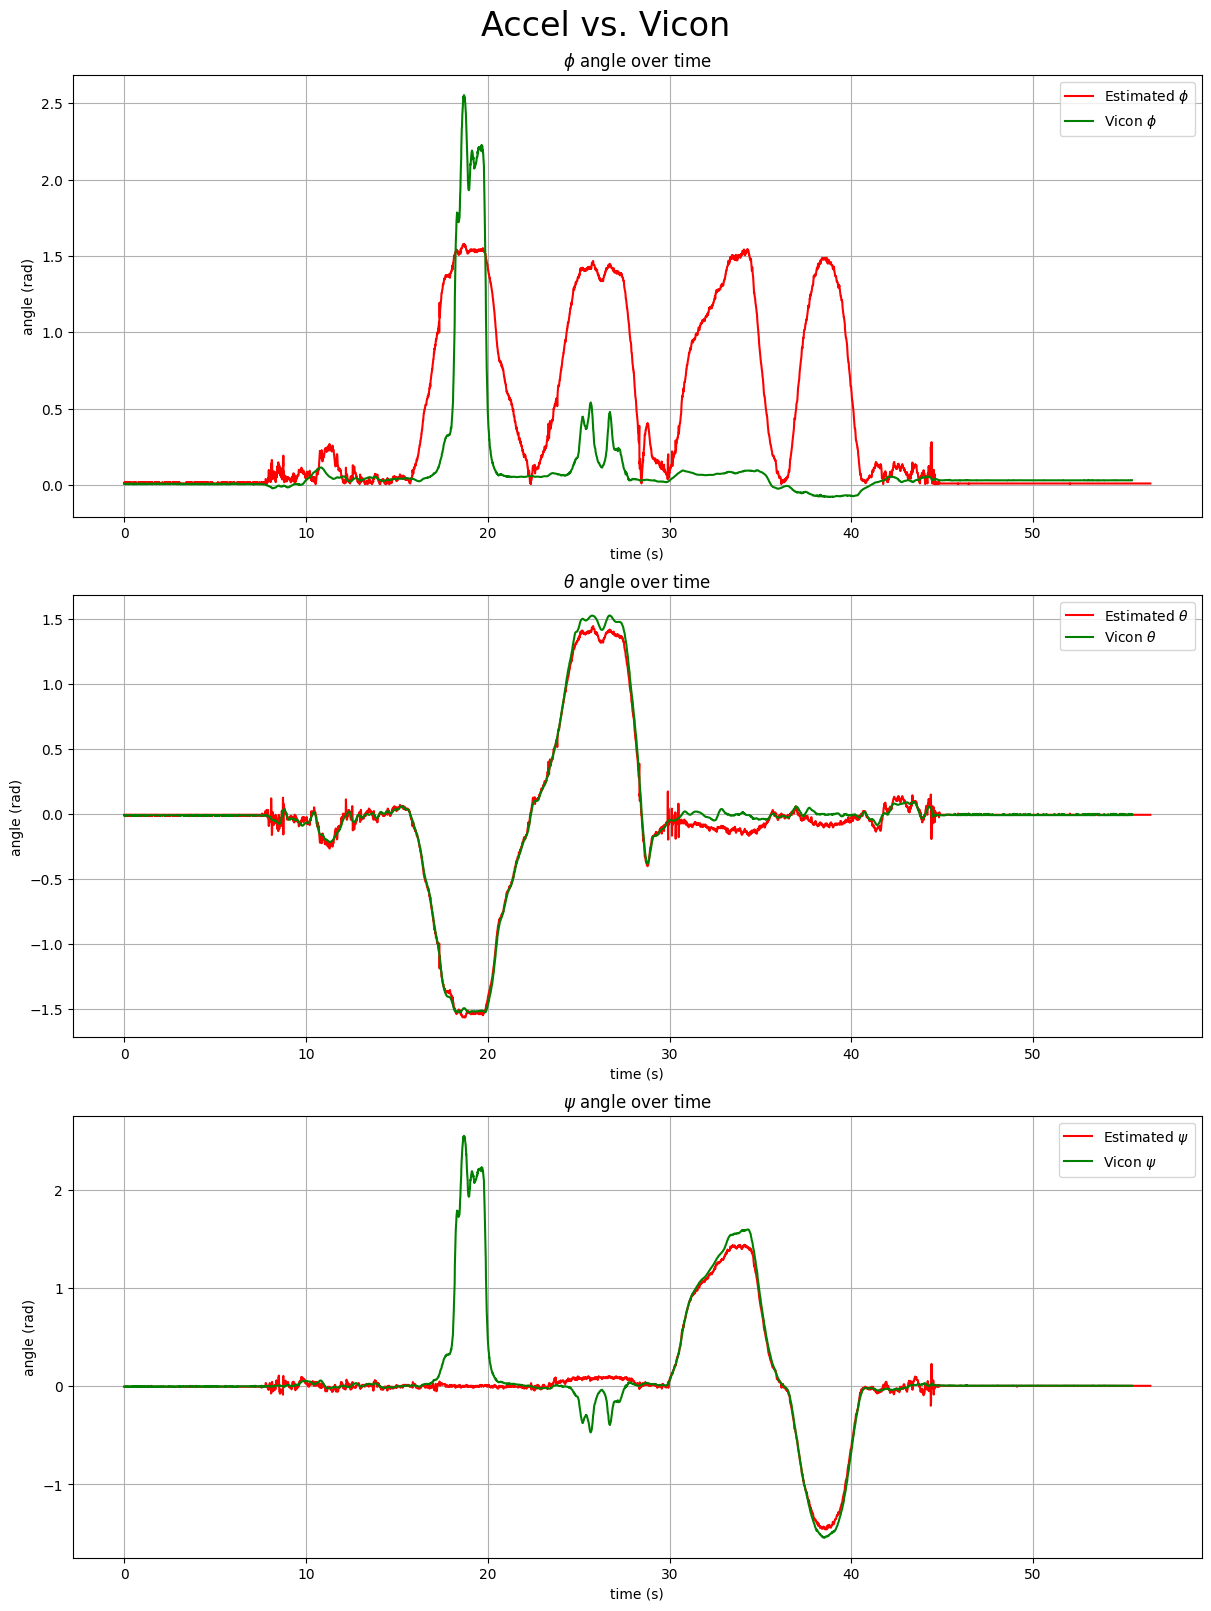

In [6]:
def LowPassFilter(x_t,x_t_next,gamma=0.2):
    return (1-gamma)*x_t_next + gamma*x_t

accel_euler_zyx_raw = np.zeros(shape=(1,3,imu_data_raw["ts"].size))


accel_euler_zyx_raw[:,2,:] = np.arctan2(imu_ay,np.sqrt(np.square(imu_ax) + np.square(imu_az)))
accel_euler_zyx_raw[:,1,:] = -np.arctan2(imu_ax,np.sqrt(np.square(imu_ay) + np.square(imu_az)))
accel_euler_zyx_raw[:,0,:] = np.arctan2(np.sqrt(np.square(imu_ax) + np.square(imu_ay)),imu_az)

# ax = rotplot(R.from_euler('zyx',accel_euler_zyx_init[:,:]).as_matrix()[0])

# ax = rotplot(R.from_euler('zyx',accel_euler_zyx_filtered[:,:,0]).as_matrix()[0])

# ax = rotplot(R.from_euler('zyx',accel_euler_zyx[:,:,5000]).as_matrix()[0],ax)
# rotplot(R.from_euler('zyx',accel_euler_zyx_raw[:,:,imu_data_raw["ts"].size-1]).as_matrix()[0],ax)
# plt.show()

# rotplot(vicon_data_raw['rots'][:,:,vicon_data_raw['ts'].size-1])
# plt.show()

# PlotEulerAnglesOverTime(accel_euler_zyx_raw,imu_t)
fig = PlotEulerAnglesOverTime(accel_euler_zyx_raw,imu_t, vicon_euler_zyx, vicon_t)
fig.suptitle('Accel vs. Vicon', fontsize=24)
plt.savefig('./Outputs/DataSet{}/AccelVsVicon.png'.format(trial_num))
plt.show()

### Complementary Filter

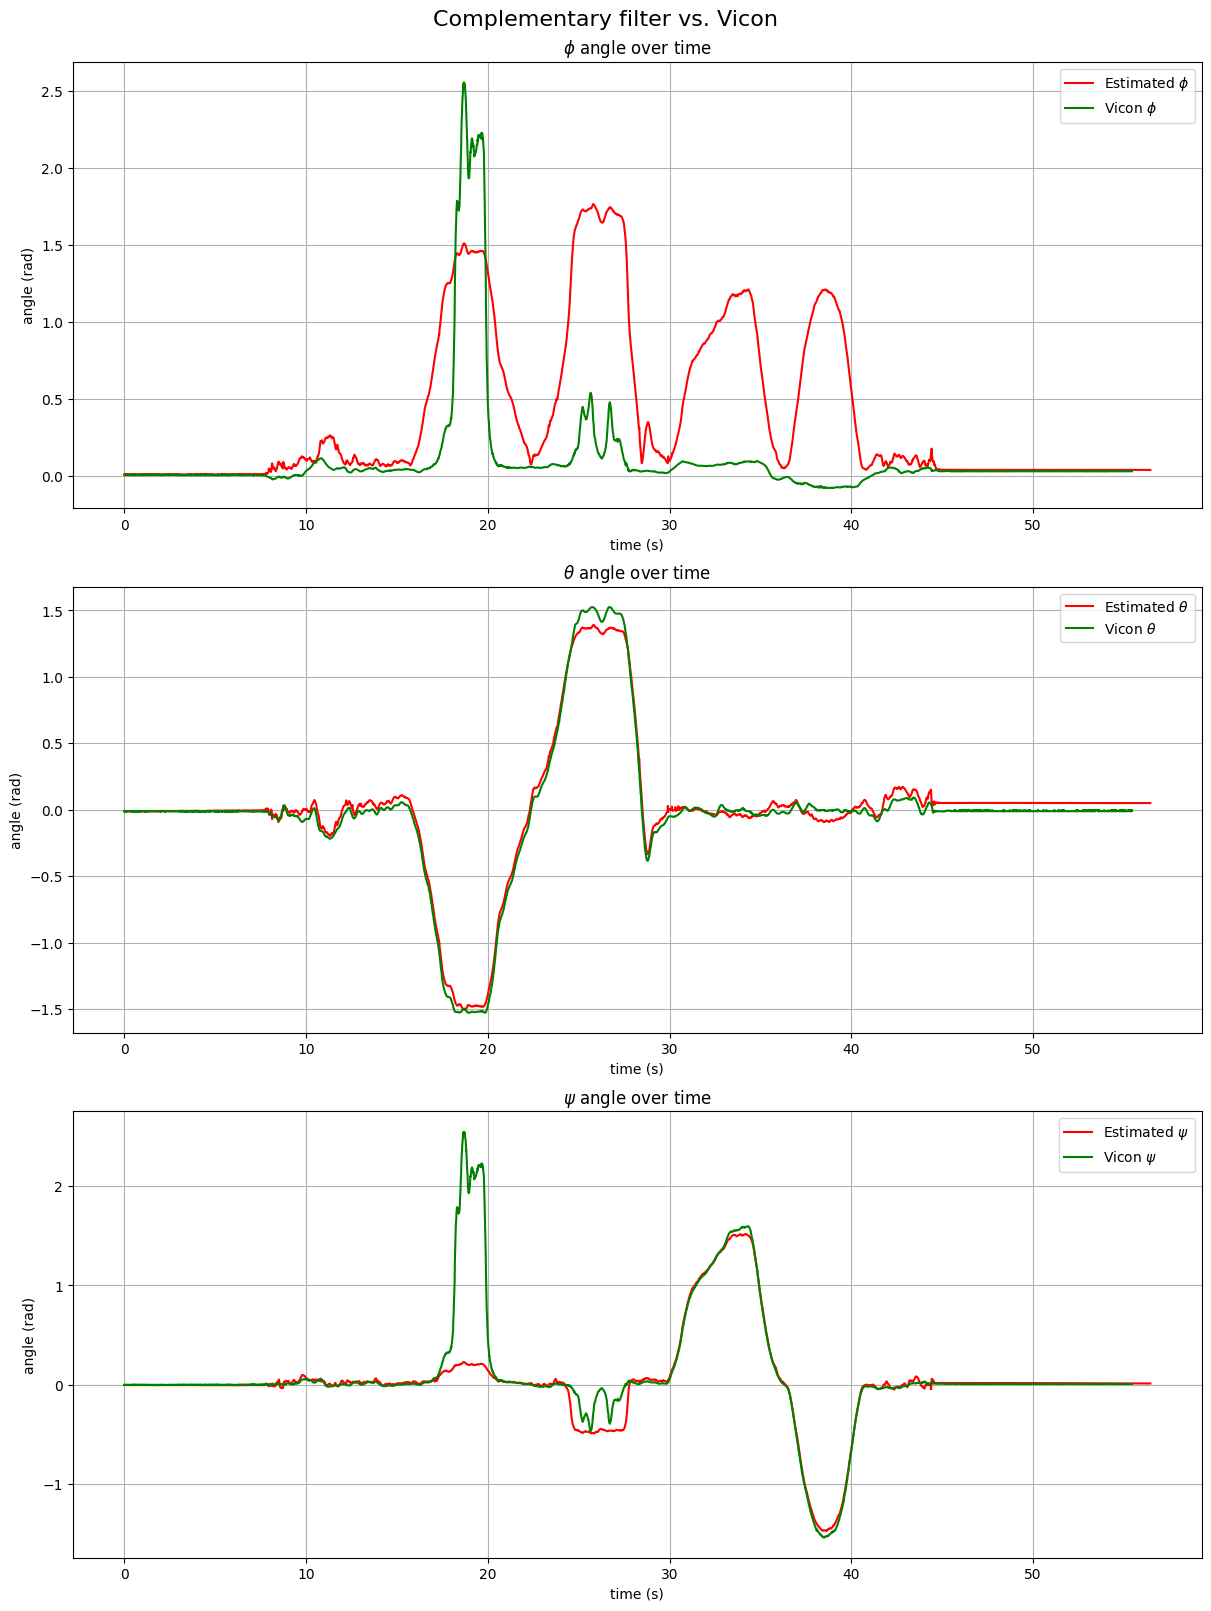

In [7]:
time_idx = 0

comp_euler_zyx = np.zeros(shape=(1,3,imu_data_raw["ts"].size))

gyro_euler_zyx_filtered = np.zeros_like(gyro_euler_zyx_raw)
gyro_euler_zyx_filtered[:,0,0] = gyro_euler_zyx_raw[:,0,0]
gyro_euler_zyx_filtered[:,1,0] = gyro_euler_zyx_raw[:,1,0]
gyro_euler_zyx_filtered[:,2,0] = gyro_euler_zyx_raw[:,2,0]
for time_idx in range(imu_data_raw["ts"].size - 1):
    gyro_euler_zyx_filtered[:,:,time_idx+1] = (1-0.0001)*gyro_euler_zyx_filtered[:,:,time_idx] + (1-0.0001)*(gyro_euler_zyx_raw[:,:,time_idx+1]-gyro_euler_zyx_raw[:,:,time_idx])

accel_euler_zyx_filtered = np.zeros(shape=(1,3,imu_data_raw["ts"].size))
accel_euler_zyx_filtered[:,0,0] = accel_euler_zyx_raw[:,0,0]
accel_euler_zyx_filtered[:,1,0] = accel_euler_zyx_raw[:,1,0]
accel_euler_zyx_filtered[:,2,0] = accel_euler_zyx_raw[:,2,0]

for time_idx in range(imu_data_raw["ts"].size - 1):    
    accel_euler_zyx_filtered[:,:,time_idx+1] = LowPassFilter(accel_euler_zyx_filtered[:,:,time_idx], accel_euler_zyx_raw[:,:,time_idx+1],0.8)


alpha = 0.8
comp_euler_zyx = (1-alpha) * gyro_euler_zyx_filtered + alpha * accel_euler_zyx_filtered

# PlotEulerAnglesOverTime(gyro_euler_zyx_filtered,imu_t)
# PlotEulerAnglesOverTime(accel_euler_zyx_filtered,imu_t)
# PlotEulerAnglesOverTime(comp_euler_zyx,imu_t)
fig = PlotEulerAnglesOverTime(comp_euler_zyx,imu_t, vicon_euler_zyx,vicon_t)
fig.suptitle('Complementary filter vs. Vicon', fontsize=16)
plt.savefig('./Outputs/DataSet{}/CompVsVicon.png'.format(trial_num))
plt.show()
